In [1]:
from pathlib import Path

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import s3fs
import statsmodels.api as sm
import xarray as xr
import zarr
from dask.distributed import Client
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def calc_climatology(t, y, harmonics: int, f: float = 1/365.2422):
    exog = np.full((harmonics * 2, len(t)), np.nan)
    for i in range(harmonics * 2):
        if i % 2 == 0:
            exog[i] = np.sin((i // 2 + 1) * 2 * np.pi * f * t)
        else:
            exog[i] = np.cos((i // 2 + 1) * 2 * np.pi * f * t)
    exog = exog.T
    exog = sm.add_constant(exog)
    endog = y
    mod = sm.OLS(endog, exog)
    res = mod.fit()
    # mod_fit = res.params@exog.T
    return res.params@exog.T, res

In [3]:
dask_dash = False

In [4]:
NOTEBOOK_DIR = Path().resolve()
FIGURES_DIR = Path(NOTEBOOK_DIR / "../../figures").resolve()
DATA_DIR = Path("/efs_ecco/ascherer/datasets")
TS_DAILY_PATH = DATA_DIR / "v4r5/surface_sal_temp_fw_daily_latlon_10N-20S_90E-120E.nc"
TS_MONTHLY_PATH = DATA_DIR / "v4r4/surface_sal_temp_fw_monthly_latlon_10N-20S_90E-120E.nc"
IOD_PATH = DATA_DIR / "iod.nc"

In [5]:
ds_daily = xr.open_dataset(TS_DAILY_PATH)
ds_monthly = xr.open_dataset(TS_MONTHLY_PATH)
iod = xr.open_dataset(IOD_PATH)

In [6]:
ds_monthly

<xarray.Dataset> Size: 3MB
Dimensions:                  (time: 312, lat: 30, lon: 30)
Coordinates:
  * time                     (time) datetime64[ns] 2kB 1992-01-16T18:00:00 .....
  * lat                      (lat) float64 240B -19.5 -18.5 -17.5 ... 8.5 9.5
  * lon                      (lon) float64 240B 90.5 91.5 92.5 ... 118.5 119.5
Data variables:
    surface_freshwater_flux  (time, lat, lon) float32 1MB ...
    sea_surface_temperature  (time, lat, lon) float32 1MB ...
    sea_surface_salinity     (time, lat, lon) float32 1MB ...
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f07693e6-4181-11eb-beb3-0cc47a3f44ff

In [16]:
if dask_dash:
    client = Client("tcp://127.0.0.1:42659")

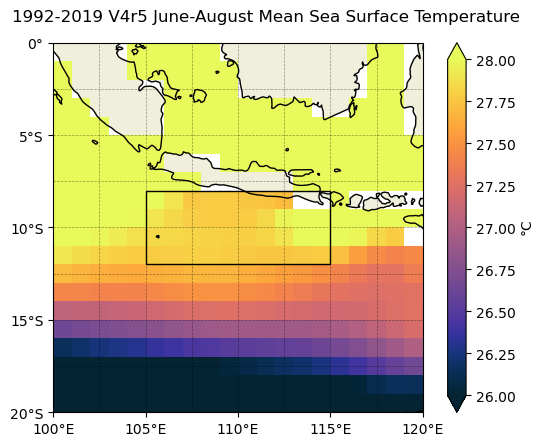

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([100, 120, -20, 0])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.OCEAN)
ds_jjs = ds_daily.where(
    (ds_daily["time.month"] >= 6) & (ds_daily["time.month"] <= 8),
    drop=True
).mean(dim="time")
pcm = ax.pcolormesh(ds_jjs["lon"], ds_jjs["lat"], ds_jjs["sea_surface_temperature"], transform=ccrs.PlateCarree(), vmin=26, vmax=28, cmap=cmo.thermal)
ax.add_patch(mpatches.Rectangle(xy=[105, -12], width=10, height=4,
                                facecolor='none', edgecolor='k',
                                transform=ccrs.PlateCarree()))
ax.gridlines(linewidth=0.5, alpha=0.4, color='k',
                  linestyle='--')
ax.set_xticks(np.arange(100, 121, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20, 1, 5), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
cbar = plt.colorbar(pcm, extend="both", label="$\\mathsf{\\degree C}$")
fig.suptitle("1992-2019 V4r5 June-August Mean Sea Surface Temperature", y=0.95)
plt.savefig(FIGURES_DIR / "sst_jja_mean.png", dpi=600, bbox_inches="tight")

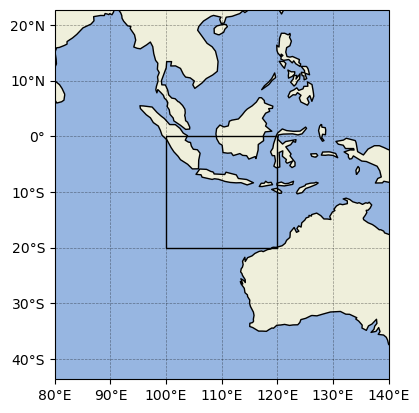

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([80, 140, -40, 20])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_patch(mpatches.Rectangle(xy=[100, -20], width=20, height=20,
                                facecolor='none', edgecolor='k',
                                transform=ccrs.PlateCarree()))
ax.gridlines(linewidth=0.5, alpha=0.4, color='k',
                  linestyle='--')
ax.set_xticks(np.arange(80, 141, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-40, 21, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
# cbar = plt.colorbar(pcm, extend="both", label="$\\mathsf{\\degree C}$")
# fig.suptitle("1992-2019 V4r5 June-August Mean Sea Surface Temperature", y=0.95)
plt.savefig(FIGURES_DIR / "indian_ocean_overview.png", dpi=600, bbox_inches="tight")

In [19]:
ds_monthly_clima = ds_monthly.groupby("time.month").mean()
ds_monthly_clima = ds_monthly_clima.sel(lon=slice(105, 115), lat=slice(-12, -8)).mean(dim=["lat", "lon"])
monthly_t_fit, monthly_t_res = calc_climatology(
    ds_monthly_clima["month"].data,
    ds_monthly_clima["sea_surface_temperature"].data,
    3,
    f=1/12,
)

ds_daily_clima = ds_daily.groupby("time.dayofyear").mean()
ds_daily_clima = ds_daily_clima.assign_coords(day=(["dayofyear"], ds_daily_clima["dayofyear"].data - 1))
ds_daily_clima = ds_daily_clima.sel(lon=slice(105, 115), lat=slice(-12, -8)).mean(dim=["lat", "lon"])
daily_t_fit, daily_t_res = calc_climatology(
    ds_daily_clima["dayofyear"].data - 1,
    ds_daily_clima["sea_surface_temperature"].data,
    3
)

In [20]:
ds_monthly_clima = ds_monthly.groupby("time.month").mean()
ds_monthly_clima = ds_monthly_clima.sel(lon=slice(105, 115), lat=slice(-12, -8)).mean(dim=["lat", "lon"])
monthly_s_fit, monthly_s_res = calc_climatology(
    ds_monthly_clima["month"].data,
    ds_monthly_clima["sea_surface_salinity"].data,
    3,
    f=1/12,
)

ds_daily_clima = ds_daily.groupby("time.dayofyear").mean()
ds_daily_clima = ds_daily_clima.assign_coords(day=(["dayofyear"], ds_daily_clima["dayofyear"].data - 1))
ds_daily_clima = ds_daily_clima.sel(lon=slice(105, 115), lat=slice(-12, -8)).mean(dim=["lat", "lon"])
daily_s_fit, daily_s_res = calc_climatology(
    ds_daily_clima["dayofyear"].data - 1,
    ds_daily_clima["sea_surface_salinity"].data,
    3
)

In [21]:
ds_harmonic_clima_daily = xr.Dataset(
    data_vars=dict(
        sea_surface_temperature=(["dayofyear"], daily_t_fit),
        sea_surface_salinity=(["dayofyear"], daily_s_fit),
    ),
    coords=dict(
        dayofyear=ds_daily_clima["dayofyear"]
    )
)
ds_harmonic_clima_monthly = xr.Dataset(
    data_vars=dict(
        sea_surface_temperature=(["month"], monthly_t_fit),
        sea_surface_salinity=(["month"], monthly_s_fit),
    ),
    coords=dict(
        dayofyear=ds_monthly_clima["month"]
    )
)

In [38]:
ds_t_anom_daily = ds_daily["sea_surface_temperature"].groupby("time.dayofyear") - ds_harmonic_clima_daily["sea_surface_temperature"]
ds_t_anom_monthly = ds_monthly["sea_surface_temperature"].groupby("time.month") - ds_harmonic_clima_monthly["sea_surface_temperature"]
ds_s_anom_daily = ds_daily["sea_surface_salinity"].groupby("time.dayofyear") - ds_harmonic_clima_daily["sea_surface_salinity"]
ds_s_anom_monthly = ds_monthly["sea_surface_salinity"].groupby("time.month") - ds_harmonic_clima_monthly["sea_surface_salinity"]
ds_monthly_anom = xr.Dataset(
    data_vars=dict(
        sea_surface_temperature=ds_t_anom_monthly,
        sea_surface_salinity=ds_s_anom_monthly,
    ),
)
ds_daily_anom = xr.Dataset(
    data_vars=dict(
        sea_surface_temperature=ds_t_anom_daily,
        sea_surface_salinity=ds_s_anom_daily,
    ),
)
ds_monthly_anom_area_mean = ds_monthly_anom.sel(lon=slice(105, 115), lat=slice(-12, -8)).mean(dim=["lat", "lon"])
ds_daily_anom_area_mean = ds_daily_anom.sel(lon=slice(105, 115), lat=slice(-12, -8)).mean(dim=["lat", "lon"])

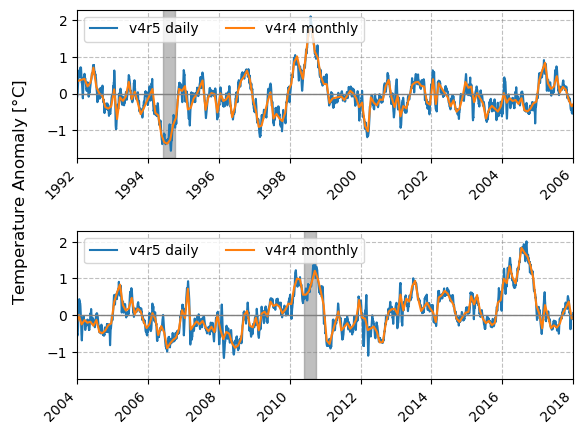

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.5) 
# ax1.plot(iod["date"], iod["iod"]/2, label="iod")
ax1.plot(ds_daily_anom_area_mean["time"], ds_daily_anom_area_mean["sea_surface_temperature"], label="v4r5 daily")
ax1.plot(ds_monthly_anom_area_mean["time"], ds_monthly_anom_area_mean["sea_surface_temperature"], label="v4r4 monthly")
ax1.set_xlim(np.datetime64("1992-01-01"), np.datetime64("2005-01-01"))
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')
ax1.axhline(0, lw=1, c="gray")
ax1.grid(c="gray", alpha=0.5, ls="--")
ax1.legend(ncols=3, loc="upper left")
# ax2.plot(iod["date"], iod["iod"]/2, label="iod")
ax2.plot(ds_daily_anom_area_mean["time"], ds_daily_anom_area_mean["sea_surface_temperature"], label="v4r5 daily")
ax2.plot(ds_monthly_anom_area_mean["time"], ds_monthly_anom_area_mean["sea_surface_temperature"], label="v4r4 monthly")
ax2.set_xlim(np.datetime64("2005-01-01"), np.datetime64("2018-01-01"))
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(0, lw=1, c="gray")
ax2.grid(c="gray", alpha=0.5, ls="--")
ax2.legend(ncols=3, loc="upper left")
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# ax.xaxis.set_tick_params(rotation=45, ha="right")
fig.supylabel("Temperature Anomaly [$\\mathsf{\\degree C}$]")
# ax.axhline(0, ls="--", c="gray", alpha=0.5)
ylim = ax1.get_ylim()
ax1.fill_betweenx(y=ylim, x1=np.datetime64("1994-06-01"), x2=np.datetime64("1994-10-01"), color="gray", alpha=0.5)
ax2.fill_betweenx(y=ylim, x1=np.datetime64("2010-06-01"), x2=np.datetime64("2010-10-01"), color="gray", alpha=0.5)
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
plt.savefig(FIGURES_DIR / "ecco_temp_time_series.png", dpi=600, bbox_inches="tight")

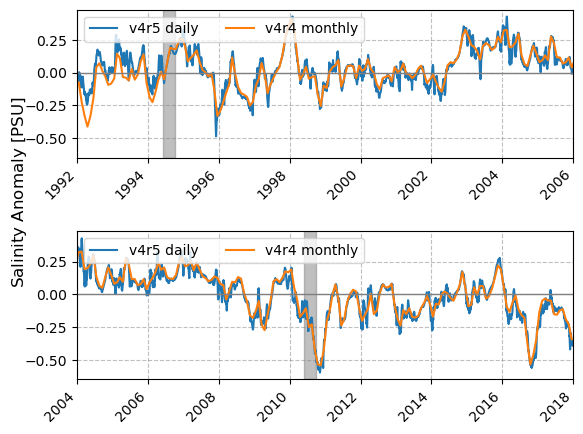

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.5) 
# ax1.plot(iod["date"], iod["iod"]/4, label="iod")
ax1.plot(ds_daily_anom_area_mean["time"], ds_daily_anom_area_mean["sea_surface_salinity"], label="v4r5 daily")
ax1.plot(ds_monthly_anom_area_mean["time"], ds_monthly_anom_area_mean["sea_surface_salinity"], label="v4r4 monthly")
ax1.set_xlim(np.datetime64("1992-01-01"), np.datetime64("2005-01-01"))
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')
ax1.axhline(0, lw=1, c="gray")
ax1.grid(c="gray", alpha=0.5, ls="--")
ax1.legend(ncols=3, loc="upper left")
# ax2.plot(iod["date"], iod["iod"]/4, label="iod")
ax2.plot(ds_daily_anom_area_mean["time"], ds_daily_anom_area_mean["sea_surface_salinity"], label="v4r5 daily")
ax2.plot(ds_monthly_anom_area_mean["time"], ds_monthly_anom_area_mean["sea_surface_salinity"], label="v4r4 monthly")
ax2.set_xlim(np.datetime64("2005-01-01"), np.datetime64("2018-01-01"))
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(0, lw=1, c="gray")
ax2.grid(c="gray", alpha=0.5, ls="--")
ax2.legend(ncols=3, loc="upper left")
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# ax.xaxis.set_tick_params(rotation=45, ha="right")
fig.supylabel("Salinity Anomaly [$\\mathsf{PSU}$]")
ylim = ax1.get_ylim()
ax1.fill_betweenx(y=ylim, x1=np.datetime64("1994-06-01"), x2=np.datetime64("1994-10-01"), color="gray", alpha=0.5)
ax2.fill_betweenx(y=ylim, x1=np.datetime64("2010-06-01"), x2=np.datetime64("2010-10-01"), color="gray", alpha=0.5)
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
plt.savefig(FIGURES_DIR / "ecco_sal_time_series.png", dpi=600, bbox_inches="tight")

In [50]:
cool_salty_time = slice(np.datetime64("1994-06-01"), np.datetime64("1994-10-01"))
warm_fresh_time = slice(np.datetime64("2010-06-01"), np.datetime64("2010-10-01"))
ds_cool_salty_monthly_time_mean = ds_monthly_anom.sel(time=cool_salty_time).mean(dim="time")
ds_warm_fresh_monthly_time_mean = ds_monthly_anom.sel(time=warm_fresh_time).mean(dim="time")

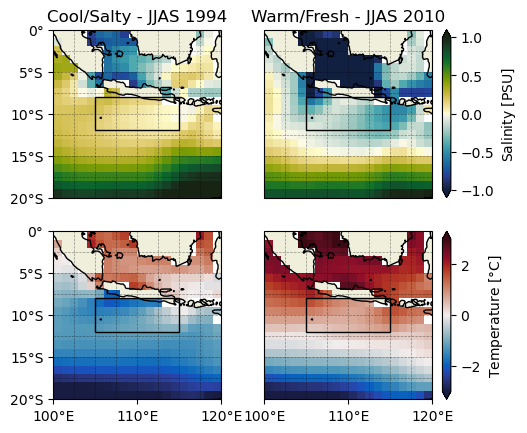

In [93]:
fig, axs = plt.subplots(2, 2, subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=-0.2) 

pcm_s = axs[0, 0].pcolormesh(
    ds_cool_salty_monthly_time_mean["lon"],
    ds_cool_salty_monthly_time_mean["lat"],
    ds_cool_salty_monthly_time_mean["sea_surface_salinity"],
    transform=ccrs.PlateCarree(),
    cmap=cmo.delta,
    vmin=-1,
    vmax=1,
)
pcm_t = axs[1, 0].pcolormesh(
    ds_cool_salty_monthly_time_mean["lon"],
    ds_cool_salty_monthly_time_mean["lat"],
    ds_cool_salty_monthly_time_mean["sea_surface_temperature"],
    transform=ccrs.PlateCarree(),
    cmap=cmo.balance,
    vmin=-3,
    vmax=3,
)

pcm_s = axs[0, 1].pcolormesh(
    ds_warm_fresh_monthly_time_mean["lon"],
    ds_warm_fresh_monthly_time_mean["lat"],
    ds_warm_fresh_monthly_time_mean["sea_surface_salinity"],
    transform=ccrs.PlateCarree(),
    cmap=cmo.delta,
    vmin=-1,
    vmax=1,
)
pcm_t = axs[1, 1].pcolormesh(
    ds_warm_fresh_monthly_time_mean["lon"],
    ds_warm_fresh_monthly_time_mean["lat"],
    ds_warm_fresh_monthly_time_mean["sea_surface_temperature"],
    transform=ccrs.PlateCarree(),
    cmap=cmo.balance,
    vmin=-3,
    vmax=3,
)

for ax in axs.flatten():
    ax.set_extent([100, 120, -20, 0])
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_patch(mpatches.Rectangle(xy=[105, -12], width=10, height=4,
                                    facecolor='none', edgecolor='k',
                                    transform=ccrs.PlateCarree()))
    ax.gridlines(linewidth=0.5, alpha=0.4, color='k',
                      linestyle='--')
    if ax == axs[0, 0] or ax == axs[1, 0]:
        ax.set_yticks(np.arange(-20, 1, 5), crs=ccrs.PlateCarree())
        ax.yaxis.set_major_formatter(LatitudeFormatter())
    if ax == axs[1, 0] or ax == axs[1, 1]:
        ax.set_xticks(np.arange(100, 121, 10), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(LongitudeFormatter())

divider = make_axes_locatable(axs[0, 1])
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = plt.colorbar(pcm_s, cax=ax_cb, extend="both")
cbar.set_label("Salinity [$\\mathsf{PSU}$]")

divider = make_axes_locatable(axs[1, 1])
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = plt.colorbar(pcm_t, cax=ax_cb, extend="both")
cbar.set_label("Temperature [$\\mathsf{\\degree C}$]")

axs[0, 0].set_title("Cool/Salty - JJAS 1994")
axs[0, 1].set_title("Warm/Fresh - JJAS 2010")

plt.savefig(FIGURES_DIR / "ecco_sal_temp_area_plot.png", dpi=600, bbox_inches="tight")